In [311]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import arviz as az
from arviz.utils import conditional_jit, Numba

import jax
from jax import random
import time
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import datetime
import os 

from sqlalchemy import create_engine

Numba.disable_numba()
Numba.numba_flag
NUM_CORES = 1
numpyro.set_host_device_count(NUM_CORES)
numpyro.set_platform('cpu')

plt.rcParams.update({'font.size': 16})

CONFIG_STRING_PATH = '../../config/sentinel_config.txt'
with open(CONFIG_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    engine = create_engine(conn_string)

In [10]:
model_ = 'chain_powers'
name_ = 'chain_powers'
QUERY = f"""
SELECT 
to_timestamp(height_to_unix(height)) AS timestamp, total_raw_bytes_power, total_raw_bytes_committed, total_qa_bytes_power, total_qa_bytes_committed, total_pledge_collateral, qa_smoothed_position_estimate, qa_smoothed_velocity_estimate, miner_count, participating_miner_count
FROM visor.{model_}
"""
pd.read_sql(QUERY, engine).to_pickle(f'../../data/{name_}_{model_}.pkl')
df_orig = pd.read_pickle(f'../../data/{name_}_{model_}.pkl')

In [11]:
df_orig.tail()

,timestamp,total_raw_bytes_power,total_raw_bytes_committed,total_qa_bytes_power,total_qa_bytes_committed,total_pledge_collateral,qa_smoothed_position_estimate,qa_smoothed_velocity_estimate,miner_count,participating_miner_count
2295960,2022-11-06 23:39:30+00:00,1.839137e+19,1.839177e+19,2.147559e+19,2.147650e+19,1.343249e+26,7.299900e+57,1.253273e+51,589986,3865
2295961,2022-11-06 23:26:00+00:00,1.839155e+19,1.839195e+19,2.147533e+19,2.147624e+19,1.343257e+26,7.299667e+57,1.191840e+51,589986,3865
2295962,2022-11-06 23:57:00+00:00,1.839137e+19,1.839177e+19,2.147569e+19,2.147660e+19,1.343250e+26,7.300196e+57,1.330337e+51,589986,3865
2295963,2022-11-06 23:26:30+00:00,1.839155e+19,1.839194e+19,2.147533e+19,2.147623e+19,1.343258e+26,7.299676e+57,1.194114e+51,589986,3865
2295964,2022-11-06 23:37:00+00:00,1.839161e+19,1.839200e+19,2.147583e+19,2.147673e+19,1.343257e+26,7.299857e+57,1.241978e+51,589986,3865


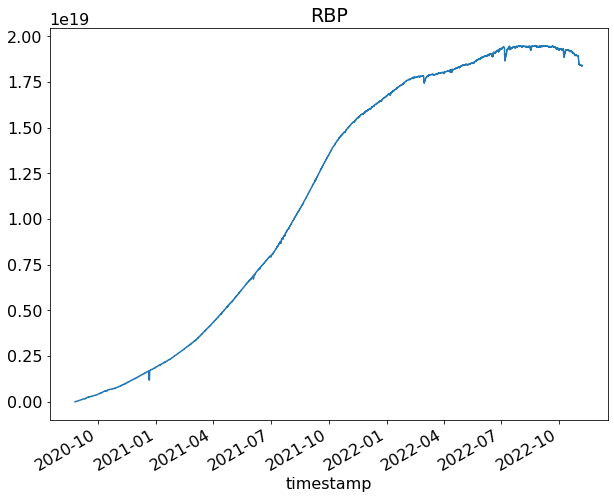

In [298]:
df = df_orig.copy()
df.index = df.timestamp
df.total_raw_bytes_power.plot(); plt.title('RBP');

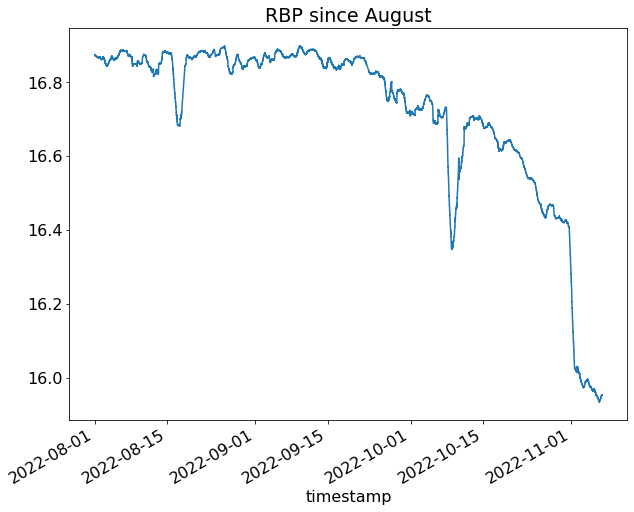

In [299]:
# Let's looked at RBP since August
EIB = 2**60
df = df[(df.timestamp > '2022-08-01')]
df['total_raw_bytes_power_eib'] = df.loc[:,'total_raw_bytes_power'] / EIB
df.total_raw_bytes_power_eib.plot(); plt.title('RBP since August');

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280185 entries, 2022-08-01 00:02:00+00:00 to 2022-11-06 23:37:00+00:00
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   timestamp                      280185 non-null  datetime64[ns, UTC]
 1   total_raw_bytes_power          280185 non-null  float64            
 2   total_raw_bytes_committed      280185 non-null  float64            
 3   total_qa_bytes_power           280185 non-null  float64            
 4   total_qa_bytes_committed       280185 non-null  float64            
 5   total_pledge_collateral        280185 non-null  float64            
 6   qa_smoothed_position_estimate  280185 non-null  float64            
 7   qa_smoothed_velocity_estimate  280185 non-null  float64            
 8   miner_count                    280185 non-null  int64              
 9   participating_miner_count      2801

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 2022-08-01 to 2022-11-07
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   total_raw_bytes_power          99 non-null     float64
 1   total_raw_bytes_committed      99 non-null     float64
 2   total_qa_bytes_power           99 non-null     float64
 3   total_qa_bytes_committed       99 non-null     float64
 4   total_pledge_collateral        99 non-null     float64
 5   qa_smoothed_position_estimate  99 non-null     float64
 6   qa_smoothed_velocity_estimate  99 non-null     float64
 7   miner_count                    99 non-null     float64
 8   participating_miner_count      99 non-null     float64
 9   total_raw_bytes_power_eib      99 non-null     float64
dtypes: float64(10)
memory usage: 8.5+ KB


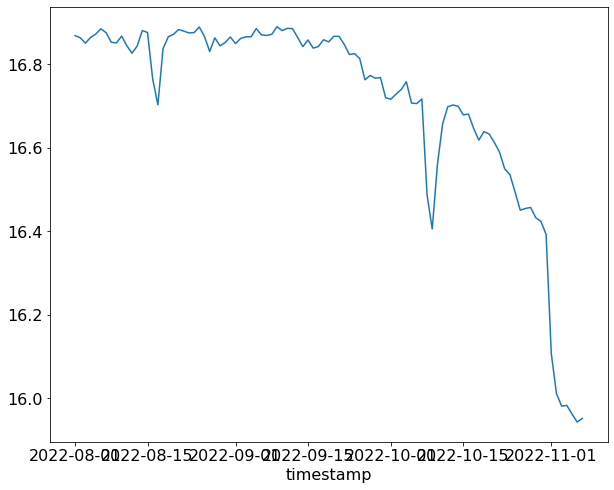

In [301]:
df_daily = df.groupby(df.timestamp.dt.date).mean()
df_daily.info()
df_daily.total_raw_bytes_power_eib.plot();

In [339]:
# data transformations
standardize = lambda x: (x - x.mean()) / x.std()
undo_standardize = lambda x_std, x: x_std * x.std() + x.mean()
logstandardize = lambda x: (np.log(x) - np.log(x).mean()) / np.log(x).std()
undo_logstandardize = lambda x, y: y * np.exp(x).std() + np.exp(x).mean()

shift = lambda x: x - x.mean()
unshift = lambda x, y: x + y.mean()

# data
Nt = len(df_daily.total_raw_bytes_power_eib.values)
X_t = df_daily.index
X, Y = jnp.arange(Nt), df_daily.total_raw_bytes_power_eib.values
X_, Y_ = X.copy(), shift(df_daily.total_raw_bytes_power_eib.values) # standardised or shift for nicer fitting

# Model
def kernel(X, Z, var, length, noise, jitter=1.0e-7, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k= var * (jnp.exp(-0.5 * deltaXsq)) 
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

def kernel_grad(X, Z, var, length, noise, jitter=1.0e-7, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = ((Z - X[:, None]) / jnp.power(length, 2.0)) * var * (jnp.exp(-0.5 * deltaXsq)) 
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

def kernel_grad2(X, Z, var, length, noise, jitter=1.0e-7, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = (1 / jnp.power(length, 2.0) + jnp.power((Z - X[:, None]) / jnp.power(length, 2.0), 2.0)) * var * (jnp.exp(-0.5 * deltaXsq)) 
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

def model(X, Y):
    var = numpyro.sample("kernel_var", dist.TruncatedNormal(low=0., loc=1., scale=1.))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(loc=1., scale=1.))
    length = numpyro.sample("kernel_length", dist.Normal(loc=30., scale=0.01))
    k = kernel(X, X, var, length, noise)
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )
    
    
def run_inference(model, rng_key, X, Y):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup = 4000,
        num_samples = 4000,
        num_chains=NUM_CORES,
        thinning=2,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples(), mcmc


def predict(rng_key, X, Y, X_test, var, length, noise):
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pp_grad = kernel_grad(X_test, X_test, var, length, noise, include_noise=True)
    k_pp_grad2 = kernel_grad2(X_test, X_test, var, length, noise, include_noise=True)
    
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_pX_grad = kernel_grad(X_test, X, var, length, noise, include_noise=False)
    k_pX_grad2 = kernel_grad2(X_test, X, var, length, noise, include_noise=False)
    
    
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    K_grad = k_pp_grad - jnp.matmul(k_pX_grad, jnp.matmul(K_xx_inv, jnp.transpose(k_pX))) - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX_grad)))
    K_grad2 = k_pp_grad2 - jnp.matmul(k_pX_grad2, jnp.matmul(K_xx_inv, jnp.transpose(k_pX))) - 2 * jnp.matmul(k_pX_grad, jnp.matmul(K_xx_inv, jnp.transpose(k_pX_grad))) - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX_grad2)))
                                    
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(rng_key, X_test.shape[:1])
    sigma_noise_grad = jnp.sqrt(jnp.clip(jnp.diag(K_grad), a_min=0.0)) * jax.random.normal(rng_key, X_test.shape[:1]) / jnp.sqrt(2 * 3.14)
    sigma_noise_grad2 = jnp.sqrt(jnp.clip(jnp.diag(K_grad2), a_min=0.0)) * jax.random.normal(rng_key, X_test.shape[:1]) / jnp.sqrt(2 * 3.14)
    
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    mean_grad = jnp.matmul(k_pX_grad, jnp.matmul(K_xx_inv, Y))
    mean_grad2 = jnp.matmul(k_pX_grad2, jnp.matmul(K_xx_inv, Y))
                                    
    return mean, mean + sigma_noise, sigma_noise, mean_grad, mean_grad + sigma_noise_grad, mean_grad2, mean_grad2 + sigma_noise_grad2

def plt_posterior_param(mcmc):
    mcmc_from_numpyro = az.from_numpyro(mcmc)
    az.plot_trace(mcmc_from_numpyro, compact = True, combined = True);
    plt.show()

    az.plot_forest(mcmc_from_numpyro, 
                   var_names = ['kernel_length', 'kernel_var', 'kernel_noise'], 
                   combined = True)
    plt.show()

    az.plot_pair(mcmc_from_numpyro, 
                 var_names = ['kernel_length', 'kernel_var', 'kernel_noise'])
    plt.show()

In [340]:
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples, mcmc = run_inference(model, rng_key, X_, Y_)

vmap_args = (
    random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
)

sample: 100%|███████████████████████████████████████████████████| 8000/8000 [00:23<00:00, 347.51it/s, 7 steps of size 8.45e-01. acc. prob=0.88]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length     30.00      0.01     30.00     29.98     30.02   1758.62      1.00
   kernel_noise      0.00      0.00      0.00      0.00      0.00   1471.99      1.00
     kernel_var      1.80      0.62      1.72      0.83      2.78   1892.36      1.00

Number of divergences: 0

MCMC elapsed time: 23.14443302154541


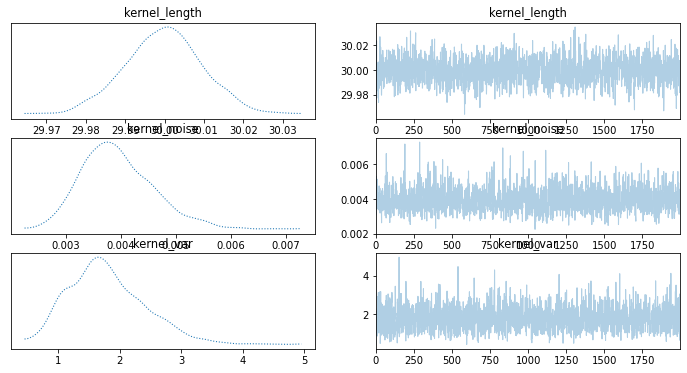

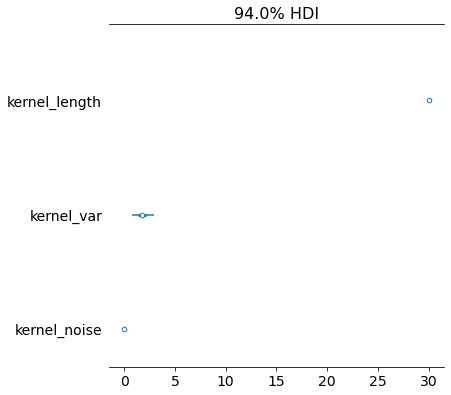

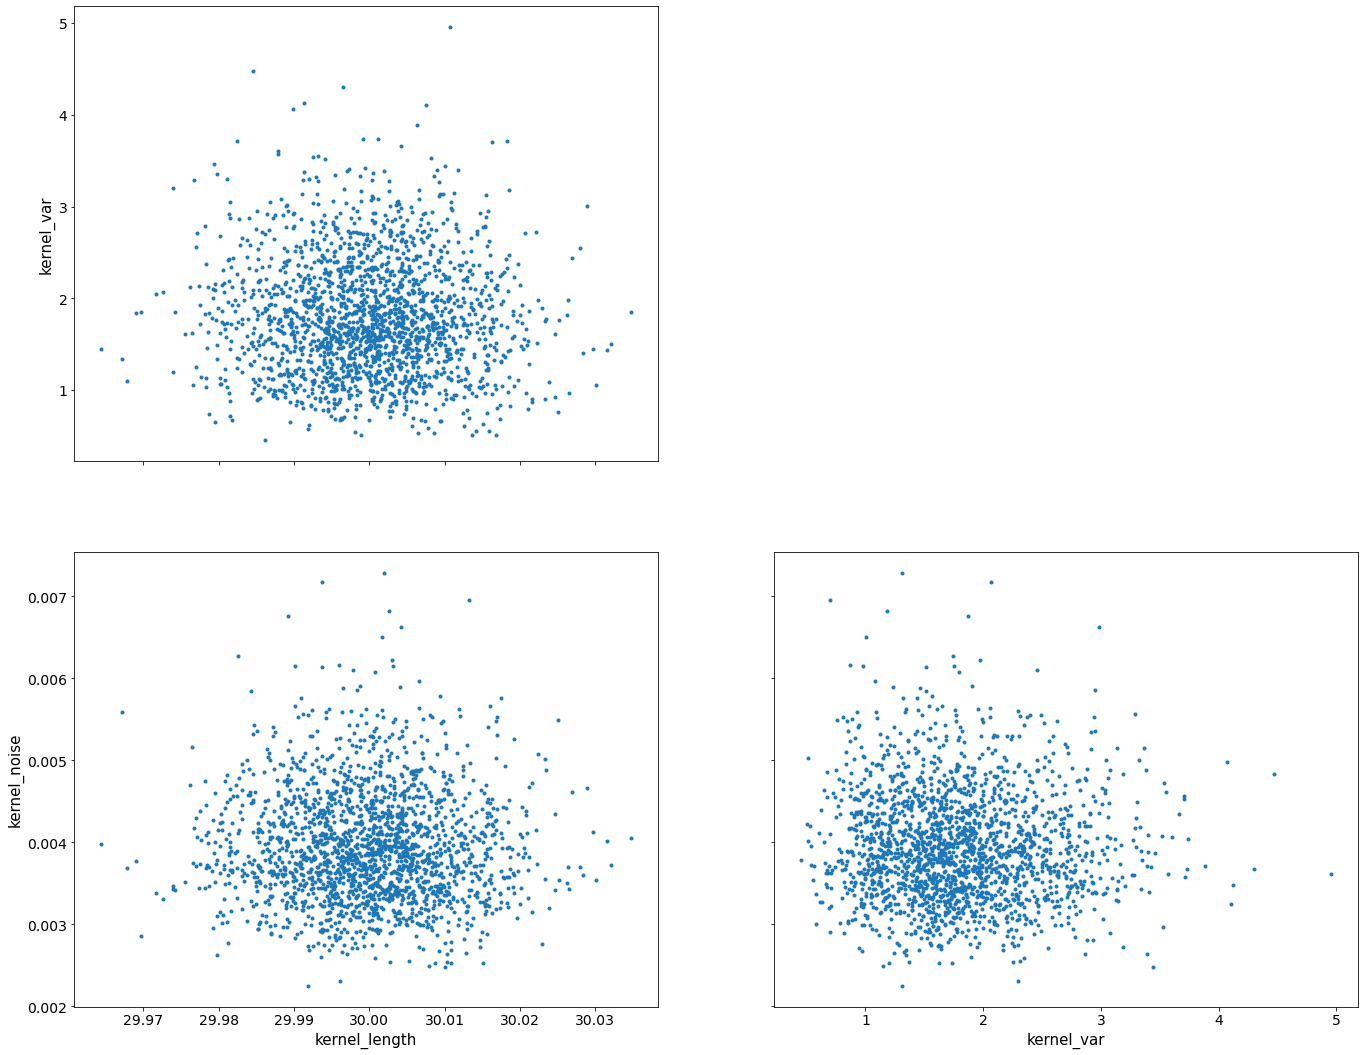

In [341]:
plt_posterior_param(mcmc)

In [342]:
N_forecast = 10
Nt_pred = Nt + N_forecast
X_test_ = np.linspace(0, Nt_pred-1, Nt_pred)

X_test_t_ = pd.date_range(df_daily.index.min(), 
                          df_daily.index.min() + datetime.timedelta(days=Nt_pred-1))

means_, preds_, sigma_noise_, mean_grads_, pred_grads_, mean_grad2s_, pred_grad2s_ = vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X_, Y_, X_test_, var, length, noise
    )
)(*vmap_args)

In [343]:
# Transform back to unstandardised space

means = np.array([unshift(means_[i], df_daily.total_raw_bytes_power_eib.values) for i in range(len(means_))])
sigma_noise = np.array([sigma_noise_[i] for i in range(len(sigma_noise_))])
preds = np.array([unshift(preds_[i],df_daily.total_raw_bytes_power_eib.values) for i in range(len(preds_))])

# if log space, the gradient is:
# mean_grads = np.array([means[i] * mean_grads_[i] for i in range(len(mean_grads_))]) 
# pred_grads = np.array([preds[i] * pred_grads_[i] for i in range(len(pred_grads_))])

mean_grads = np.array([mean_grads_[i] for i in range(len(mean_grads_))]) 
pred_grads = np.array([pred_grads_[i] for i in range(len(pred_grads_))]) 

In [344]:
X_test_t_.shape == X_test_.shape, X_t.shape == Y.shape

(True, True)

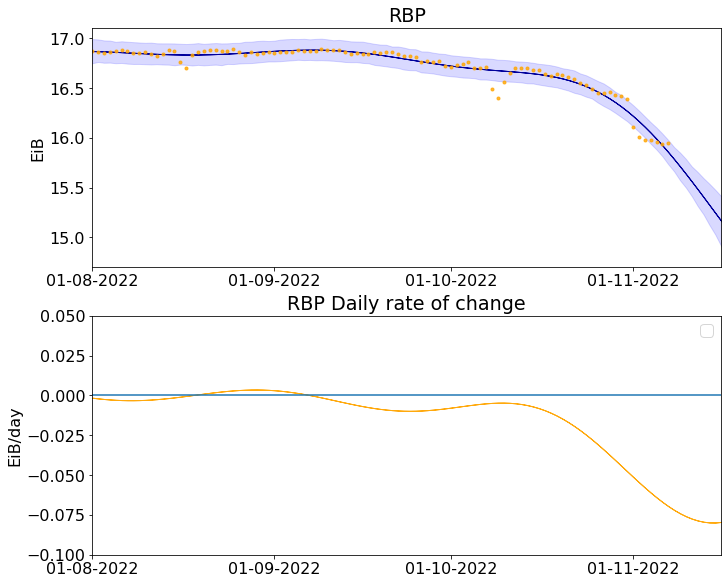

In [345]:
# QAP mean and CI
mean_prediction = np.mean(means, axis=0)
percentiles50 = np.percentile(preds, [25.0, 75.0], axis=0)
percentiles75 = np.percentile(preds, [12.50, 87.50], axis=0)
percentiles90 = np.percentile(preds, [5.0, 95.0], axis=0)

# QAP gradient CI
mean_grad_prediction = np.mean(mean_grads, axis=0)
pred_grads50 = np.percentile(pred_grads, [25.0, 75.0], axis=0)
pred_grads75 = np.percentile(pred_grads, [12.5, 87.5], axis=0)
pred_grads90 = np.percentile(pred_grads, [5.0, 95.0], axis=0)

# QAP rate (log gradient) CI
mean_grad_prediction_ = np.mean(mean_grads_, axis=0)
pred_grads50_ = np.percentile(pred_grads_, [25.0, 75.0], axis=0)
pred_grads75_ = np.percentile(pred_grads_, [12.5, 87.5], axis=0)
pred_grads90_ = np.percentile(pred_grads_, [5.0, 95.0], axis=0)


plt.rcParams['figure.figsize'] = [10, 8]
fig, (ax1, ax2, ) = plt.subplots(2,1, constrained_layout=True)

ax1.plot(X_t, Y, ".", color='orange', alpha = 0.8, label="fitting data")
ax1.set_title("RBP")
ax1.fill_between(X_test_t_, mean_prediction, mean_prediction, label = "GP w/ 90 BCI", color="darkblue")
ax1.fill_between(X_test_t_, percentiles90[0, :], percentiles90[1, :], color="blue", alpha = 0.15)
ax1.set_xlim(X_test_t_[0],X_test_t_[-2])
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.set_ylabel("EiB")

ax2.fill_between(X_test_t_, mean_grad_prediction, mean_grad_prediction, color="orange", alpha = 0.95)
ax2.hlines(0,X_test_t_[0],X_test_t_[-1])
ax2.set_xlim(X_test_t_[0],X_test_t_[-2])
ax2.set_ylim(-0.1,0.05)
ax2.set_ylabel("EiB/day")
ax2.legend()
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.set_title("RBP Daily rate of change")

plt.show()